In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras as tfk

from sklearn.preprocessing import StandardScaler
from keras.callbacks import Callback

from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, LayerNormalization

from tensorflow.keras.regularizers import L2

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
plt.style.use('seaborn')
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from utils import preprocess_time_series_v2

Using TensorFlow backend.


In [2]:
df = pd.read_csv('REE_2016_2020_gluonTS.csv')

X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess_time_series_v2(df, date_init='2016', date_final='2017', date_val='2018', date_test='2019', 
                            past_timestamps=96, forecasting_horizon=6, 
                            standarize=True, metafeatures=False, tendency=False)

/home/blasting/TFG_TimeSeries/notebooks/utils.py:131: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  val_data = df[date_val].to_numpy()
/home/blasting/TFG_TimeSeries/notebooks/utils.py:132: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test_data = df[date_test].to_numpy()
                      Date  value
0      2016-01-02 23:00:00  24151
1      2016-01-03 00:00:00  22170
2      2016-01-03 01:00:00  20691
3      2016-01-03 02:00:00  19737
4      2016-01-03 03:00:00  19437
...                    ...    ...
34940  2019-12-28 19:00:00  29282
34941  2019-12-28 20:00:00  29266
34942  2019-12-28 21:00:00  28022
34943  2019-12-28 22:00:00  25964
34944  2019-12-2

In [5]:
n_neurons = int(2/3*(X_train.shape[1]*X_train.shape[2]))


inputs = tfk.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out = tfk.layers.LSTM(n_neurons, return_sequences=True)(inputs)
lstm_out = tfk.layers.LSTM(n_neurons)(lstm_out)
outputs = tfk.layers.Dense(y_train.shape[1], activation='linear')(lstm_out)

model = tfk.Model(inputs=inputs, outputs=outputs)
model.compile(loss=tfk.losses.MeanSquaredError(), optimizer= tfk.optimizers.Adam(),
metrics=[tfk.metrics.MeanAbsoluteError()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 96, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 50,310
Trainable params: 50,310
Non-trainable params: 0
_________________________________________________________________


In [9]:
batch_size = 256
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=20, 
                    validation_data=(X_val, y_val)) 


loss = history.history['loss']            #entrenamiento
val_loss = history.history['val_loss']    #validacion
#val_mse = history.history['val_mse']    #validacion
#mse = history.history['mse']    #validacion


Epoch 1/20
68/68 [==============================] - 31s 454ms/step - loss: 0.0141 - mean_absolute_error: 0.0851 - val_loss: 0.0206 - val_mean_absolute_error: 0.0959
Epoch 2/20
68/68 [==============================] - 28s 407ms/step - loss: 0.0150 - mean_absolute_error: 0.0870 - val_loss: 0.0192 - val_mean_absolute_error: 0.0940
Epoch 3/20
68/68 [==============================] - 31s 450ms/step - loss: 0.0175 - mean_absolute_error: 0.0934 - val_loss: 0.0214 - val_mean_absolute_error: 0.0994
Epoch 4/20
68/68 [==============================] - 27s 397ms/step - loss: 0.0139 - mean_absolute_error: 0.0846 - val_loss: 0.0191 - val_mean_absolute_error: 0.0935
Epoch 5/20
68/68 [==============================] - 26s 390ms/step - loss: 0.0135 - mean_absolute_error: 0.0838 - val_loss: 0.0188 - val_mean_absolute_error: 0.0914
Epoch 6/20
68/68 [==============================] - 26s 389ms/step - loss: 0.0135 - mean_absolute_error: 0.0824 - val_loss: 0.0189 - val_mean_absolute_error: 0.0897
Epoch 7/20

In [10]:
model.save('LSTM_150_2.h5')

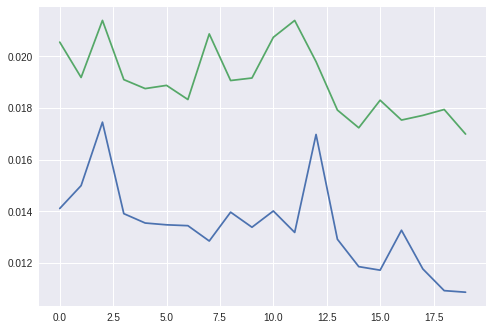

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [12]:
def inverse_transform(yhat, y, scaler):
	return scaler.inverse_transform(y),  scaler.inverse_transform(yhat)


In [13]:
y_hat = model.predict(X_test)
y_hat_2 = model.predict(X_val)

y_test, y_hat = inverse_transform(y_hat, y_test, scaler)
y_val, y_hat_2 = inverse_transform(y_hat_2, y_val, scaler)

In [26]:
plt.style.use('science')


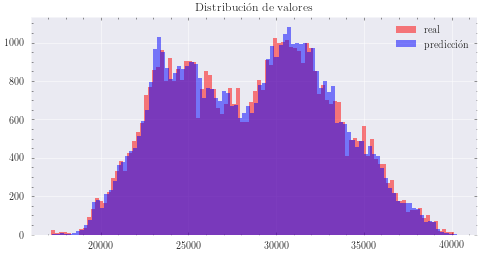

In [46]:
plt.figure(figsize=(8, 4))
plt.hist(y_test.flatten(), bins=100, color='r', alpha=0.5, label="real")
plt.hist(y_hat.flatten(), bins=100, color='b', alpha=0.5, label="predicción")
plt.legend()
plt.title('Distribución de valores')
plt.show()

In [37]:
y_hat[:, 0].shape

(8587,)

In [40]:
y_test.shape

(8587, 6)

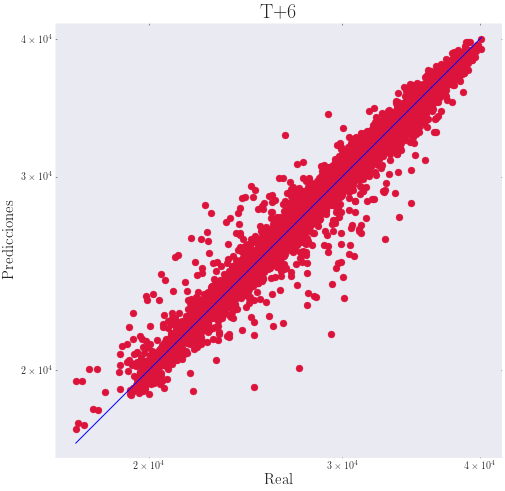

In [53]:
plt.figure(figsize=(8,8))
plt.scatter(y_test[:, 5], y_hat[:, 5], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_hat[:, 5]), max(y_test[:, 5]))
p2 = min(min(y_hat[:, 5]), min(y_test[:, 5]))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Real', fontsize=15)
plt.ylabel('Predicciones', fontsize=15)
plt.axis('equal')
plt.title('T+6', fontsize=20)

plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts(test, forecasts, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = mean_absolute_error(actual, predicted)
		print('t+%d MSE: %f' % ((i+1), rmse))

In [15]:
print("test")
evaluate_forecasts(y_test, y_hat, 6)

print("validacion")
evaluate_forecasts(y_val, y_hat_2, 6)

test
t+1 MSE: 268.214873
t+2 MSE: 337.114581
t+3 MSE: 372.439439
t+4 MSE: 423.889682
t+5 MSE: 449.754215
t+6 MSE: 481.037276
validacion
t+1 MSE: 266.519893
t+2 MSE: 333.716922
t+3 MSE: 363.208850
t+4 MSE: 412.139414
t+5 MSE: 436.890413
t+6 MSE: 465.260692


In [17]:
(268.214873 + 337.114581 + 372.439439 + 423.889682 + 449.754215 + 481.037276)/6

388.74167766666665